# PSF normalization

Let us assume that we have reduced an observation, for which we have determined the PSF by stacking the flux of point-like sources. The PSF we obtain will not be as high S/N as the instrumental PSF that has been determined by the instrument team. Moreover, it is likely to be fattened due to the some small pointing errors. We need to find out what fraction of a point-like flux the PSF we have determined represent. In order to do this, we use the growth curve of the theoretical PSF that has been determine by the instrument team, and compare it to the growth curve we determine from our PSF.

We will first look at a theoretical case, then go practical with an example drawn from the PACS observation of the the XMM-LSS.

## 1) Theoretical example. 

Let us suppose we have a perfect telescope, without any central obscuration and spider to support the secondary. Diffraction theory gives us the shape of a PSF in this case, an Airy function. Let's compute it, and assume the resolution is 10".


In [1]:
# import what we will need. 
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii as asciiread
from matplotlib import pyplot as plt
from scipy import interpolate 
from scipy import special
from scipy import signal
from scipy import fftpack

In [2]:
# Let us perform our computation with a 0.1" resolution on a 5' field of view
resol = 0.1
size = 300.
# wavelength
wavelength = 250e-6
# primary aperture = 3.6 m diameter
aperture = 3.6 / 2.

In [3]:
# Ensure we have an odd number of points 
nbpix = np.ceil(size/resol) // 2 * 2 + 1
xcen = int((nbpix - 1) / 2)
ycen = int((nbpix - 1) / 2)
x = y = (np.arange(nbpix) - xcen)*resol
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
r = np.sqrt(xv**2+yv**2)
# avoid division by 0 problems in the center
r[xcen,ycen] = 1e-6
# coordinates in fourier
q = 2 * np.pi / wavelength * aperture * np.sin(r/3600.*np.pi/180.)

In [4]:
psf = (2*special.jn(1, q)/q)**2

In [5]:
# put back the correct value at center
psf[xcen, ycen] = 1.
# and normalize the PSF
psf = psf/(np.sum(psf)*resol**2)

$\int\int$ psf dx dy = 1.0000000000000018


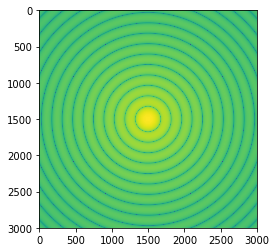

In [6]:
plt.imshow(np.log10(psf))
print(r'$\int\int$ psf dx dy = {}'.format(np.sum(psf)*resol**2))

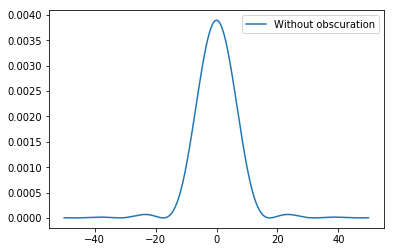

In [7]:
plt.plot(y[ycen-500:ycen+500], psf[ycen-500:ycen+500, xcen], label='Without obscuration')
plt.legend()

Let us now suppose that we observe a point source, and our image reconstruction has a ...This will shows a a blurring of the image, with a gaussian of 10" FWHM. Let's generate this blurring

In [8]:
fwhm = 10.
sigma = fwhm / 2. / np.sqrt(2. * np.log(fwhm))
sigmasq = sigma**2
kernel_blur = 1./ 2./ np.pi / sigmasq * np.exp(-(r**2/2./sigmasq))

In [9]:
# Check our kernel is properly normalized
np.sum(kernel_blur*resol**2)

0.9999999999999996

In [10]:
# apply the blur
psfblur = signal.convolve(psf, kernel_blur, mode='same')*resol**2

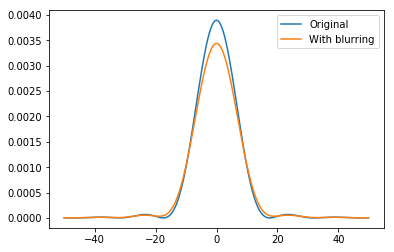

In [11]:
plt.plot(y[ycen-500:ycen+500], psf[ycen-500:ycen+500, xcen], label='Original')
plt.plot(y[ycen-500:ycen+500], psfblur[ycen-500:ycen+500, xcen], label='With blurring')
plt.legend()

We see the effect of blurring, the, observed PSF is wider, and we have lost some flux in the central core. Suppose now that we observed this psf with sources of unknown fluxes, so that we re unsure of its scaling, and that a background remain in our observation

In [12]:
psfobs = psfblur * 2. + 1e-4

The question is now how to recover the PSF that serve for our observation. For this, we will use the PSFs curve of growth. 

In [13]:
radii = np.arange(0, np.max(r), resol)
growth_psf = np.zeros(radii.shape)
growth_psfobs = np.zeros(radii.shape)
nbpix_psfobs = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    if ((i % 100) == 0):
        print(radius, np.max(radii))
    if i == 0:
        idj, idi = np.where(r <= radius)
        growth_psf[i] = np.sum(psf[idj, idi])*resol**2
        growth_psfobs[i] = np.sum(psfobs[idj, idi])*resol**2
        nbpix_psfobs[i] =len(idi)
    else:
        idj, idi = np.where((r > radii[i-1]) & (r <= radius))
        growth_psf[i] = growth_psf[i-1]+np.sum(psf[idj, idi])*resol**2
        growth_psfobs[i] = growth_psfobs[i-1]+np.sum(psfobs[idj, idi])*resol**2
        nbpix_psfobs[i] = nbpix_psfobs[i-1]+len(idi)

0.0 212.10000000000002
10.0 212.10000000000002
20.0 212.10000000000002
30.0 212.10000000000002
40.0 212.10000000000002
50.0 212.10000000000002
60.0 212.10000000000002
70.0 212.10000000000002
80.0 212.10000000000002
90.0 212.10000000000002
100.0 212.10000000000002
110.0 212.10000000000002
120.0 212.10000000000002
130.0 212.10000000000002
140.0 212.10000000000002
150.0 212.10000000000002
160.0 212.10000000000002
170.0 212.10000000000002
180.0 212.10000000000002
190.0 212.10000000000002
200.0 212.10000000000002
210.0 212.10000000000002


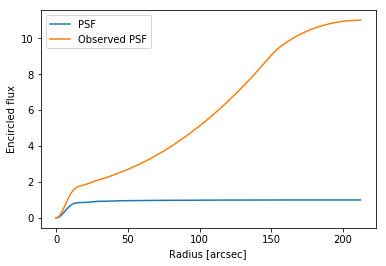

In [14]:
plt.plot(radii, growth_psf, label='PSF')
plt.plot(radii, growth_psfobs, label='Observed PSF')
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

This strongly rising shape of the observed PSF is a sure sign of an non zero background. Let's determine it. 

Text(0, 0.5, 'Encircled flux')

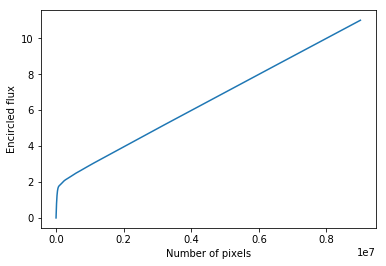

In [15]:
plt.plot(nbpix_psfobs, growth_psfobs)
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

When plotted as a function of the intergated area, there is a clear linear relation, that we will fit:

In [16]:
idx, = np.where(radii > 50)
p = np.polyfit(nbpix_psfobs[idx], growth_psfobs[idx], 1)
bkg = p[0]/resol**2

In [17]:
# Correct PSF and curve of growth
psfcor = psfobs-bkg
growth_psfcor = growth_psfobs - bkg*nbpix_psfobs*resol**2

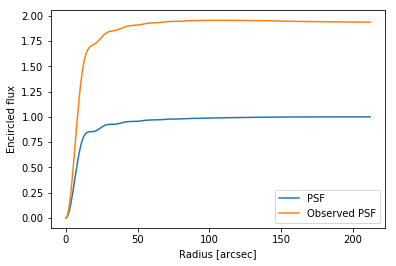

In [18]:
plt.plot(radii, growth_psf, label='PSF')
plt.plot(radii, growth_psfcor, label='Observed PSF')
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

<a id='direct_ratio'></a> Let's have a look at the ratio of the two:

Text(0, 0.5, 'Ratio of encircled flux')

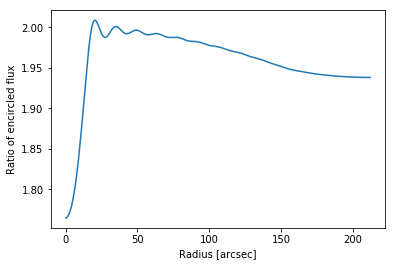

In [19]:
plt.plot(radii[1:], growth_psfcor[1:]/growth_psf[1:])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Ratio of encircled flux')


Due to the different resolution, the ratio is not constant. Let's note the calibration $C(r)$. Let us assume that our observed PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF. If we differentiate as a function of $r$:

$E'(r) = \alpha \beta C'(r \times \beta)$



In [20]:
# compute the derivatives
deriv_growth_psf = (growth_psf[2:]-growth_psf[0:-2])/(radii[2:]-radii[0:-2])
deriv_growth_psfcor  = (growth_psfcor[2:]-growth_psfcor[0:-2])/(radii[2:]-radii[0:-2])

(0, 60)

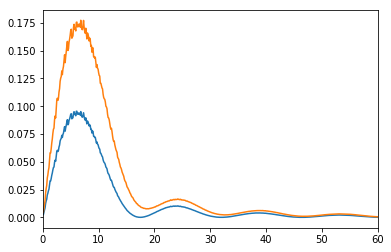

In [21]:
plt.plot(radii[1:-1], deriv_growth_psf)
plt.plot(radii[1:-1], deriv_growth_psfcor)
plt.xlim([0,60])

Compared with the growth curve plot, the derivative show clear maxima and minima that are out of phase. Findind the positions of the these will tell us if our assumption of homothetical variation is correct.

[ 0.          6.18050404 17.4854638  23.79928199 32.07353691 38.40607579
 46.76238796] [ 0.          6.5206172  18.75895207 24.07489413 32.78746844 38.5386345
 47.21468159]


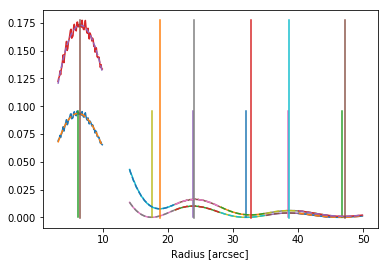

In [22]:
# Find the local minima and maxima of the two curves.
# To find a local extremum, we will fit the portion of curve with a degree 3 polynomial, 
# extract the roots of its derivative and only retain the one that are between the bounds.
# This is what the following function does.
def local_max(xvalues, yvalues, lower_bound, upper_bound, check_plot=False):
    idx,=np.where((xvalues > lower_bound) & (xvalues < upper_bound))
    p = np.polyfit(xvalues[idx], yvalues[idx], 3)
    delta = (2.*p[1])**2 - 4.*3.*p[0]*p[2]
    r1 = (-2*p[1]+np.sqrt(delta))/(2*3*p[0])
    r2 = (-2*p[1]-np.sqrt(delta))/(2*3*p[0])
    result = r1 if ((r1 > lower_bound) and (r1 < upper_bound)) else r2
    if check_plot:
        plt.plot(xvalues[idx], yvalues[idx])
        plt.plot(xvalues[idx], p[0]*xvalues[idx]**3+p[1]*xvalues[idx]**2+
                 p[2]*xvalues[idx]+p[3], '--')
        plt.plot(np.array([result, result]), np.array([np.min(yvalues), np.max(yvalues)]), '-')
    return result
    
    
max_dpsf_1 = local_max(radii[1:-1], deriv_growth_psf, 3, 10, check_plot=True)
max_dpsfcor_1 = local_max(radii[1:-1], deriv_growth_psfcor, 3, 10, check_plot=True)

max_dpsf_2 = local_max(radii[1:-1], deriv_growth_psf, 14, 21, check_plot=True)
max_dpsfcor_2 = local_max(radii[1:-1], deriv_growth_psfcor, 14, 21, check_plot=True)

max_dpsf_3 = local_max(radii[1:-1], deriv_growth_psf, 21, 28, check_plot=True)
max_dpsfcor_3 = local_max(radii[1:-1], deriv_growth_psfcor, 21, 28, check_plot=True)

max_dpsf_4 = local_max(radii[1:-1], deriv_growth_psf, 28, 35, check_plot=True)
max_dpsfcor_4 = local_max(radii[1:-1], deriv_growth_psfcor, 28, 35, check_plot=True)

max_dpsf_5 = local_max(radii[1:-1], deriv_growth_psf, 35, 45, check_plot=True)
max_dpsfcor_5 = local_max(radii[1:-1], deriv_growth_psfcor, 35, 45, check_plot=True)

max_dpsf_6 = local_max(radii[1:-1], deriv_growth_psf, 40, 50, check_plot=True)
max_dpsfcor_6 = local_max(radii[1:-1], deriv_growth_psfcor, 40, 50, check_plot=True)

plt.xlabel('Radius [arcsec]')

# Lets pack all of them, adding the r=0 point. 
max_dpsf = np.array([0, max_dpsf_1, max_dpsf_2, max_dpsf_3, max_dpsf_4, max_dpsf_5, max_dpsf_6])
max_dpsfcor = np.array([0, max_dpsfcor_1, max_dpsfcor_2, max_dpsfcor_3, max_dpsfcor_4, 
                        max_dpsfcor_5, max_dpsfcor_6])

print(max_dpsf,max_dpsfcor)

From the plot, we can deduce that our homothetical assumption is not perfect: the spacing increases for the first three (don't forget the point at 0, 0, not shown), is very small for the 4th and 6th, and gets narrower for the 5th and 7th...
Let's plot the situation

[ 1.07402639 -0.04610159]
1.0550300032613567
1.072831254463463


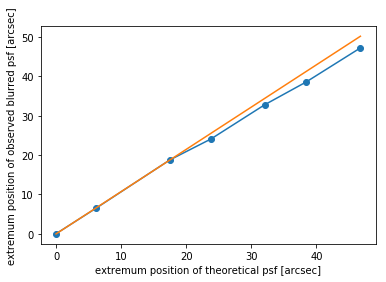

In [23]:
plt.plot(max_dpsf, max_dpsfcor, 'o-')
p = np.polyfit(max_dpsf[0:3], max_dpsfcor[0:3], 1)
plt.plot(max_dpsf, p[0]*max_dpsf+p[1])
plt.xlabel('extremum position of theoretical psf [arcsec]')
plt.ylabel('extremum position of observed blurred psf [arcsec]')


print(p)
print((max_dpsfcor[1]-max_dpsfcor[0])/(max_dpsf[1]-max_dpsf[0]))
print((max_dpsfcor[2]-max_dpsfcor[0])/(max_dpsf[2]-max_dpsf[0]))



Text(0, 0.5, 'Encircled flux')

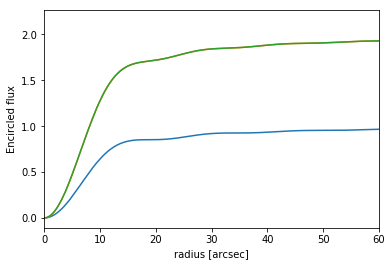

In [24]:
# Lets use the data before 20", corresponding to the central core
beta = (max_dpsfcor[2]-max_dpsfcor[0])/(max_dpsf[2]-max_dpsf[0])

# lets interpolate at the scaled radius
tckpsfcor = interpolate.splrep(radii, growth_psfcor, s=0)
interp_growth_psfcor = interpolate.splev(radii*beta, tckpsfcor, der=0)

# check interpolation
plt.plot(radii*beta, growth_psf)
plt.plot(radii, growth_psfcor)
plt.plot(radii*beta, interp_growth_psfcor)
plt.xlim([0,60])
plt.xlabel('radius [arcsec]')
plt.ylabel('Encircled flux')



Let us check the ratio, using the psf with a corrected radius

alpha = 2.005


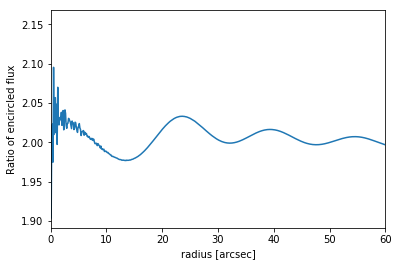

In [25]:
plt.plot(radii[1:]*beta, interp_growth_psfcor[1:]/growth_psf[1:])
plt.xlabel('radius [arcsec]')
plt.ylabel('Ratio of encircled flux')
plt.xlim([0,60])
idx, = np.where(((radii*p[0]) > 0) & ((radii*p[0]) < 60))
scale_factor = np.median(interp_growth_psfcor[idx]/growth_psf[idx])
print("alpha = {:.3f}".format(scale_factor))

We now have a much better looking ratio [compared with the cell where we computed the direct ratio](#the_ratio), and we have a decent determination of the psf scaling. The normalized PSF to use for our observations is then:

In [26]:
psf_obs_norm = psfcor / scale_factor

In [27]:
print('\int \int psf_obs_norm dx dy = {}'.format(np.sum(psf_obs_norm)*resol**2))

\int \int psf_obs_norm dx dy = 0.966450534666256


Indeed, let's look at the encircled energy in the core of our psf:
In this example, we have used the derivative of the scale factor

In [28]:
idj, idi = np.where(r<max_dpsfcor_2)
print('central core for observation: {}'.format(np.sum(psf_obs_norm[idj, idi])*resol**2))
idj, idi = np.where(r<max_dpsf_2)
print('central core for theoretical: {}'.format(np.sum(psf[idj, idi])*resol**2))




central core for observation: 0.8526531289184243
central core for theoretical: 0.8526789463354869


The two agree extremely well. 

Unfortunately, with real data, it is not always possible as we will see to use the derivative of the curve of growth to derive the factor beta of PSF fattening. For real observation, one can use a brute force approach to try all the reasonable couples alpha, beta and try to match the theoretical psf to the observed one. This is how we will proceed next on real data.

## 2) Real data: PACS observations

We will look at a real stack of point sources in the PACS 100 $\mathrm{\mu m}$ ELAIS-N1 observations, and try to find its normalization factor. 

Let's load the stacked PSF:

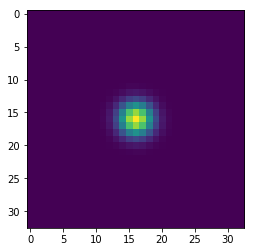

In [59]:
stackhd = fits.open('./data/ELAIS-N2-100um-psffromstack-model.fits')
psf = stackhd[0].data
hd = stackhd[0].header
plt.imshow(psf)

Set the resolution of the psf. Because the map is in units of Jy/pixel, this turns out to be:
* =1 if psf at same resolution of map
* otherwise, should be in factor of map pixel size

In [50]:
#resol= np.abs(stackhd[0].header['CDELT1'])/np.abs(stackhd_m[0].header['CDELT1'])

In [51]:
#resol

Now let's build the growthcurve for our PSF.

In [60]:
# find the brightest pixel, it will be our center.
jmax, imax = np.unravel_index(np.argmax(psf), psf.shape)

In [61]:
# build the array of coordinates
x = np.arange(hd['NAXIS1'])
y = np.arange(hd['NAXIS2'])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
xp = (xv-imax)*np.abs(hd['CDELT1'])*3600.
yp = (yv-jmax)*np.abs(hd['CDELT2'])*3600.
r = np.sqrt(xp**2 + yp**2)


In [62]:
# build the growth curve
radii = np.unique(r)
encircled_flux = np.zeros(radii.shape)
nbpix = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    idj, idi = np.where(r <= radius)
    nbpix[i] =len(idi)
    encircled_flux[i] = np.sum(psf[idj, idi])*resol**2

In [63]:
hd['CDELT1']*3600.

-2.0000000484

Text(0, 0.5, 'Encircled flux')

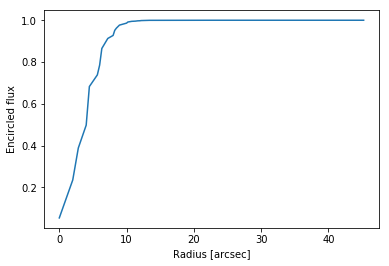

In [64]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Looking at the shape of the encircled flux, it looks like the background level of our PSF is not zero. Let's check

In [65]:
# This is clearly. 
print(np.median(psf[0:5,:]))

3.605368123892872e-22


Text(0, 0.5, 'Encircled flux')

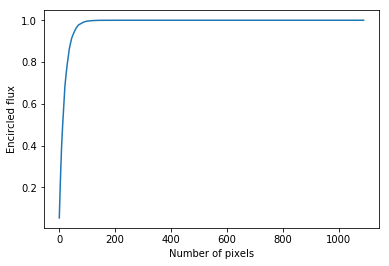

In [66]:
plt.plot(nbpix, encircled_flux)
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

In [67]:
# Lets do a linear fit to the outer part of the curve to determine the backgound
p = np.polyfit(nbpix[5000:], encircled_flux[5000:], 1)
bkg = p[0]/resol**2

TypeError: expected non-empty vector for x

In [202]:
nbpix[5000]

50101.0

In [203]:
print(bkg)

-3.26292443046e-06


In [204]:
# Lets correct the psf and encircled flux
psf = psf - bkg
encircled_flux = encircled_flux - bkg * nbpix*resol**2

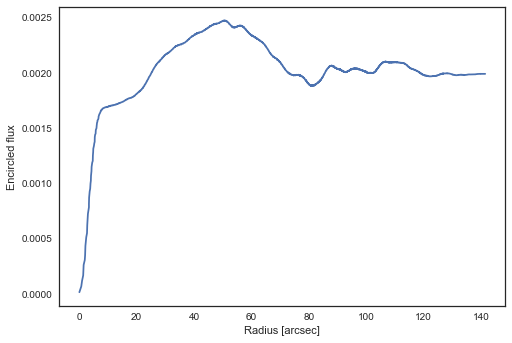

In [205]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Our PSF does now behaves correctly.

Now let us compare our growth curve with the encircled energy curve provided by the instrument team. We use the standard growth curve for 100 µm PACS, taken with 20"/s scan speed. 

In [206]:
f = open('../data/PACS/EEF_grn_20.txt', 'r')
lines = f.readlines()
f.close()
radiuseff = np.zeros(len(lines)-3)
valeff = np.zeros(len(lines)-3)
i = 0
for line in lines:
    if line[0] != '#':
        bits = line.split()
        radiuseff[i] = float(bits[0])
        valeff[i] = float(bits[1])
        i = i+1

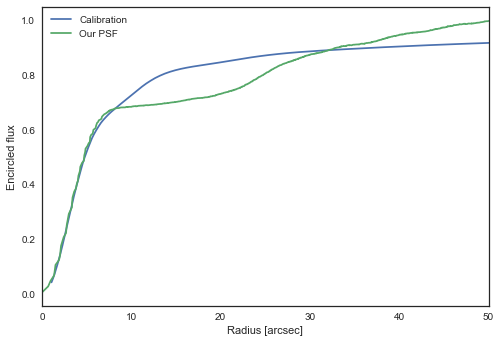

In [207]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 50])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We will work below 30" where our PSF is well behaved

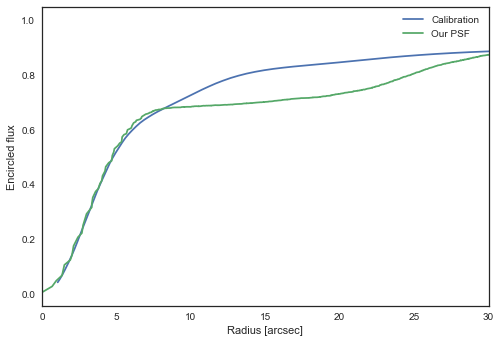

In [208]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We see that while the calibration curve still rises beyond 30", our PSF has reached a plateau. Let's note the calibration $C(r)$. Our PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF.

We could take the derivative, but this too noisy. Instead we do a brute force approach

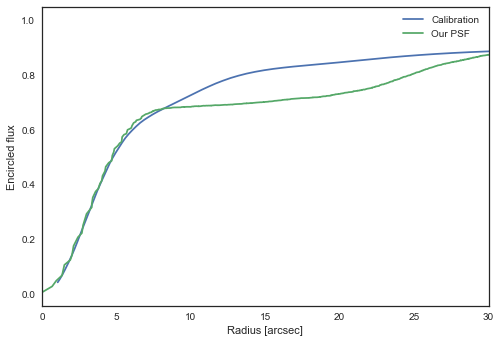

In [209]:
plt.plot(radiuseff, valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [210]:
rfactor = np.arange(1.,2., 1e-3)
ffactor = np.arange(1.,2., 1e-3)
# work with the data points between 3 and 25"
idx, = np.where((radii > 2) & (radii < 10))
xv = radii[idx]
yv = encircled_flux[idx]/np.max(encircled_flux)
resid = np.zeros((len(rfactor), len(ffactor)))
for i, rf in enumerate(rfactor):
    print(i, rf)
    tck = interpolate.splrep(radiuseff*rf, valeff, s=0)
    yfit = interpolate.splev(xv, tck, der=0)
    for j, ff in enumerate(ffactor):
        resid[i, j] = np.sum((yv-yfit*ff)**2)


0 1.0
1 1.001
2 1.002
3 1.003
4 1.004
5 1.005
6 1.006
7 1.007
8 1.008
9 1.009
10 1.01
11 1.011
12 1.012
13 1.013
14 1.014
15 1.015
16 1.016
17 1.017
18 1.018
19 1.019
20 1.02
21 1.021
22 1.022
23 1.023
24 1.024
25 1.025
26 1.026
27 1.027
28 1.028
29 1.029
30 1.03
31 1.031
32 1.032
33 1.033
34 1.034
35 1.035
36 1.036
37 1.037
38 1.038
39 1.039
40 1.04
41 1.041
42 1.042
43 1.043
44 1.044
45 1.045
46 1.046
47 1.047
48 1.048
49 1.049
50 1.05
51 1.051
52 1.052
53 1.053
54 1.054
55 1.055
56 1.056
57 1.057
58 1.058
59 1.059
60 1.06
61 1.061
62 1.062
63 1.063
64 1.064
65 1.065
66 1.066
67 1.067
68 1.068
69 1.069
70 1.07
71 1.071
72 1.072
73 1.073
74 1.074
75 1.075
76 1.076
77 1.077
78 1.078
79 1.079
80 1.08
81 1.081
82 1.082
83 1.083
84 1.084
85 1.085
86 1.086
87 1.087
88 1.088
89 1.089
90 1.09
91 1.091
92 1.092
93 1.093
94 1.094
95 1.095
96 1.096
97 1.097
98 1.098
99 1.099
100 1.1
101 1.101
102 1.102
103 1.103
104 1.104
105 1.105
106 1.106
107 1.107
108 1.108
109 1.109
110 1.11
111 1.111
112 

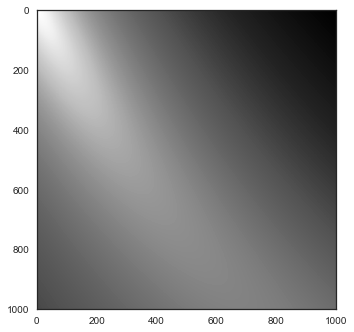

In [211]:
plt.imshow(np.log(resid))

This shows a minimum, with some degeneracy. 

In [212]:
imin = np.argmin(resid)
rmin, fmin = np.unravel_index(imin, resid.shape)
print("rf = {:.3f}, ff = {:.3f}, residual = {:.3f}".format(rfactor[rmin], ffactor[fmin], resid[rmin, fmin]))

rf = 1.000, ff = 1.000, residual = 0.024


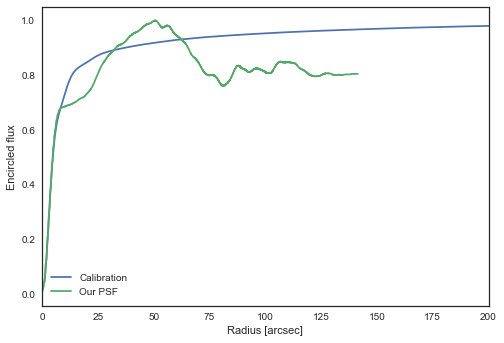

In [213]:
plt.plot(radiuseff*rfactor[rmin], valeff, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux)/ffactor[fmin], label='Our PSF')
plt.xlim([0, 200])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [214]:
# The two curve overlap
psfok = psf/np.max(encircled_flux)/ffactor[fmin]
np.sum(psfok)

7.239737

psfok is the PSF that a source of flux 1 Jy has in our data, and is to be used for source extraction

### Validation
To check PSF is reasonable, lets look at a 100 micron source, e.g. `EN1-PACSxID24-ELAIS-N1-HerMES-1-29844`. We can see from `WP4-ELAIS-N1-HerMES-PACSxID24-v1.fits.gz` that it has a flux of 55 mJy. Maximum value in our normalised PSF gives a peak below. Since PSF is three times resolution of map, it could also be off centre. 


In [215]:
from astropy.table import Table

In [216]:
PACScat=Table.read('../data/ELAIS-N1/WP4-ELAIS-N1-HerMES-PACSxID24-v1.fits.gz')

In [217]:
PACScat[PACScat['HELP_ID']=='EN1-PACSxID24-ELAIS-N1-HerMES-1-29844']

XID,RA,Dec,F_PACS_100__A4,F_PACS_100__A5,F_PACS_100__A6,F_PACS_100__A7,F_PACS_100__A8,F_PACS_100__A10,F_PACS_100,Ferr_PACS_100__A4,Ferr_PACS_100__A5,Ferr_PACS_100__A6,Ferr_PACS_100__A7,Ferr_PACS_100__A8,Ferr_PACS_100__A10,Ferr_PACS_100,F_PACS_100__SKY,F_PACS_160__A4,F_PACS_160__A5,F_PACS_160__A6,F_PACS_160__A7,F_PACS_160__A8,F_PACS_160__A10,F_PACS_160,Ferr_PACS_160__A4,Ferr_PACS_160__A5,Ferr_PACS_160__A6,Ferr_PACS_160__A7,Ferr_PACS_160__A8,Ferr_PACS_160__A10,Ferr_PACS_160,F_PACS_160__SKY,HELP_ID
,Degrees,Degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy / pix,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy / pix,
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str37
1425,243.636,54.4345,57.2211,53.53,53.1979,53.545,55.8204,49.5568,55.3478,11.1253,10.4247,10.5557,10.9084,11.5531,13.1853,8.18286,0.0,105.169,107.135,112.444,119.527,122.018,123.281,115.052,19.2912,16.3355,15.3392,14.6758,14.3281,14.8458,11.5986,0.0,EN1-PACSxID24-ELAIS-N1-HerMES-1-29844


In [218]:

print("Max PSF = {:.4f} Jy/pixel, off pixel Max PSF = {:.4f} Jy/pixel".format(psfok[cpix-1,cpix-1]*0.055,psfok[cpix-2,cpix-2]*0.055))

Max PSF = 0.0027 Jy/pixel, off pixel Max PSF = 0.0026 Jy/pixel


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


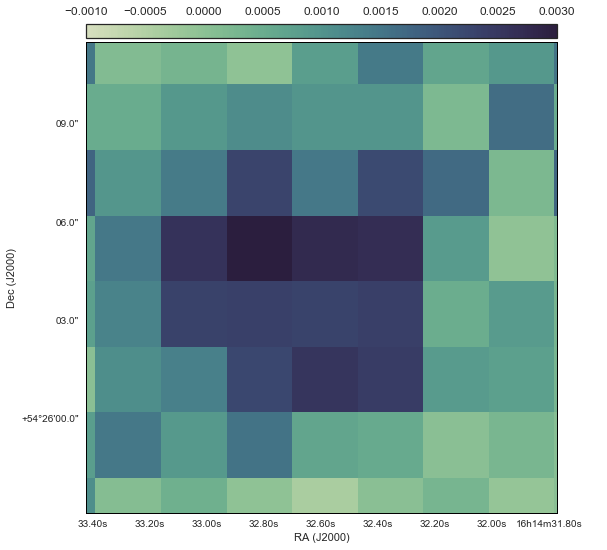

In [219]:
import aplpy
import seaborn as sns
sns.set_style("white")
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
fig=aplpy.FITSFigure('../../dmu26/data/ELAIS_N1/PACS/ELAIS-N1-100um-img_wgls.fits')
fig.recenter(PACScat[PACScat['HELP_ID']=='EN1-PACSxID24-ELAIS-N1-HerMES-1-29844']['RA'],PACScat[PACScat['HELP_ID']=='EN1-PACSxID24-ELAIS-N1-HerMES-1-29844']['Dec'], radius=0.002)
fig.show_colorscale(vmin=-0.001,vmax=0.003,cmap=cmap)
fig.add_colorbar()
fig.colorbar.set_location('top')

In summary, the PSF is within 10% of this source, and given noise and shape of source will add additional uncertianty, as well as non-zero background, this seems reasonable.


## Create PSF fits file¶


In [220]:
stackhd[1].data=psfok
stackhd.writeto('dmu18_PACS_100_PSF_ELAIS-N1_20170720.fits',output_verify='fix+warn', overwrite=True)

 [astropy.io.fits.verify]


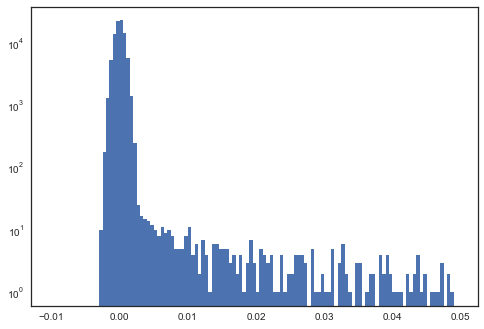

In [223]:
plt.hist(psfok.flatten(),bins=np.arange(-0.01,0.05,0.0005));
plt.yscale('log')

In [222]:
np.max(psfok)

0.04898978